In [28]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"  

import matplotlib
#matplotlib.use('Agg')  # No GUI calls

import matplotlib.pyplot as plt

In [29]:
import torch
from torch import nn
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [30]:
batch_size=32

In [31]:
import random
random.seed(42)

In [32]:
data_output = pd.read_csv("C:/Users/met48/Desktop/TS-Clustering/SimData/bank_reserves_outputs_poor.csv", header=None)
data_output_helper = data_output
new_row = [500] * data_output_helper.shape[1]
data_output_helper.loc[len(data_output_helper)] = new_row
scaler = MinMaxScaler()
scaler.fit(data_output_helper)
data_output_scaled = scaler.transform(data_output)
data_output = pd.DataFrame(data_output_scaled)

# --- Load the conditioning input parameters ---
data_input = pd.read_csv("C:/Users/met48/Desktop/TS-Clustering/SimData/bank_reserves_inputs.csv", sep=" ", header=None)

# --- Combine input + output ---
data = pd.concat([data_input, data_output], axis=1)

# --- Sample to 1280 examples if needed ---
data = data.sample(n=10000, random_state=1)

# --- Split into training and validation sets ---
train_data_pd, valid_data = train_test_split(data, test_size=0.2, random_state=42)

# --- Extract tensors for training ---
train_inputs = torch.tensor(train_data_pd.iloc[:, :1].values, dtype=torch.float32)


train_outputs = torch.tensor(train_data_pd.iloc[:, 1:].values, dtype=torch.float32)

valid_inputs = torch.tensor(valid_data.iloc[:, :1].values, dtype=torch.float32)
valid_outputs = torch.tensor(valid_data.iloc[:, 1:].values, dtype=torch.float32)

In [33]:
data

,0,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,100
3915,78.432312,0.0,0.0,0.0,0.002,0.004,0.010,0.012,0.018,0.024,...,0.054,0.062,0.058,0.058,0.064,0.062,0.064,0.062,0.062,0.058
28069,45.022241,0.0,0.0,0.0,0.002,0.006,0.012,0.024,0.036,0.038,...,0.236,0.232,0.236,0.242,0.248,0.234,0.236,0.236,0.226,0.232
80496,23.626896,0.0,0.0,0.0,0.000,0.002,0.006,0.012,0.016,0.018,...,0.292,0.290,0.300,0.296,0.296,0.306,0.306,0.304,0.320,0.316
51846,32.434221,0.0,0.0,0.0,0.002,0.004,0.010,0.022,0.032,0.044,...,0.288,0.292,0.296,0.298,0.308,0.310,0.316,0.318,0.318,0.312
55195,11.637353,0.0,0.0,0.0,0.000,0.000,0.006,0.010,0.020,0.036,...,0.264,0.266,0.262,0.262,0.274,0.274,0.288,0.282,0.284,0.284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10392,16.113799,0.0,0.0,0.0,0.002,0.006,0.012,0.020,0.032,0.038,...,0.276,0.288,0.292,0.274,0.288,0.296,0.290,0.280,0.284,0.282
53615,76.524316,0.0,0.0,0.0,0.002,0.006,0.004,0.008,0.010,0.014,...,0.066,0.062,0.064,0.066,0.064,0.068,0.066,0.072,0.074,0.074
39527,49.750516,0.0,0.0,0.0,0.000,0.004,0.008,0.014,0.016,0.024,...,0.238,0.238,0.246,0.240,0.228,0.226,0.224,0.224,0.228,0.226
2239,55.437397,0.0,0.0,0.0,0.000,0.008,0.016,0.022,0.032,0.028,...,0.182,0.180,0.182,0.180,0.180,0.180,0.180,0.184,0.182,0.184


In [34]:
train_inputs.shape[0]

8000

In [35]:
torch.manual_seed(1)

In [36]:
train_data_length = train_inputs.shape[0]
train_data = torch.from_numpy(train_data_pd.values).float().to('cpu')
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
train_data.shape

torch.Size([8000, 102])

In [37]:
from torch.utils.data import Dataset

class ConditionalTimeSeriesDataset(Dataset):
    def __init__(self, time_series_data, condition_data):
        """
        time_series_data: Tensor of shape (N, 252)
        condition_data: Tensor of shape (N, 3)
        """
        self.time_series_data = time_series_data
        self.condition_data = condition_data

    def __len__(self):
        return len(self.time_series_data)

    def __getitem__(self, idx):
        return self.time_series_data[idx], self.condition_data[idx]

In [38]:
from torch.utils.data import DataLoader

train_dataset = ConditionalTimeSeriesDataset(train_outputs, train_inputs)
valid_dataset = ConditionalTimeSeriesDataset(valid_outputs, valid_inputs)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

In [41]:
input_dim_var=101
class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_dim=input_dim_var, condition_dim=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, conditions):
        # Concatenate time series and condition
        x = torch.cat([x, conditions], dim=1)
        return self.model(x)

In [42]:
discriminator = ConditionalDiscriminator()

In [48]:
from torchsummary import summary
print(discriminator)

ConditionalDiscriminator(
  (model): Sequential(
    (0): Linear(in_features=102, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [24]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, condition_dim=1, output_len=101, hidden_dim=64):
        super().__init__()
        self.input_proj = nn.Linear(latent_dim + condition_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.output_proj = nn.Linear(hidden_dim, 1)
        self.output_len = output_len

    def forward(self, z, conditions):
        batch_size = z.size(0)
        x = torch.cat([z, conditions], dim=1)
        x = self.input_proj(x)  # (B, H)

        # Repeat across time steps
        x = x.unsqueeze(1).repeat(1, self.output_len, 1)  # (B, T, H)
        lstm_out, _ = self.lstm(x)
        out = self.output_proj(lstm_out).squeeze(-1)  # (B, T)
        return out

generator = ConditionalGenerator()

In [27]:
from torchviz import make_dot

# Instantiate model
generator = ConditionalGenerator()

# Create example inputs
batch_size = 2
latent_dim = 100
condition_dim = 1

z = torch.randn(batch_size, latent_dim)
conditions = torch.randn(batch_size, condition_dim)

# Forward pass
output = generator(z, conditions)

# Generate network graph
dot = make_dot(output, params=dict(generator.named_parameters()))
dot.render("conditional_generator_network", format="png")

'conditional_generator_network.png'

In [7]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

from graphviz import Digraph
dot = Digraph(format='png')
dot.attr(rankdir='TB', size='6,10')  # Top-to-bottom layout

# Styles
dot.attr('node', shape='ellipse', style='filled', fillcolor='lightblue', fontsize='12', fontname='Helvetica')
dot.node('z', 'Latent Vector (z)\n[B, latent_dim]')
dot.node('cond', 'Condition Vector\n[B, condition_dim]')

dot.attr('node', shape='box', style='rounded,filled', fillcolor='white', fontsize='12', fontname='Helvetica')
dot.node('concat', 'Concatenate z + cond\n→ [B, latent+cond]')
dot.node('linear1', 'Linear Layer (input_proj)\n→ [B, H]')
dot.node('repeat', 'Repeat across time\n→ [B, T, H]')
dot.node('lstm', 'LSTM\n→ [B, T, H]')
dot.node('linear2', 'Linear (output_proj)\n→ [B, T, 1]')
dot.node('squeeze', 'Squeeze\n→ [B, T]')

# Connections
dot.edge('z', 'concat')
dot.edge('cond', 'concat')
dot.edge('concat', 'linear1')
dot.edge('linear1', 'repeat')
dot.edge('repeat', 'lstm')
dot.edge('lstm', 'linear2')
dot.edge('linear2', 'squeeze')

# Render
dot.render('clean_vertical_generator_diagram', view=True)

'clean_vertical_generator_diagram.png'

In [15]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [16]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [17]:
for epoch in range(num_epochs):
    for n, (real_samples, condition_vectors) in enumerate(train_loader):
        # real_samples: (batch_size, 252)
        # condition_vectors: (batch_size, 3)

        real_samples_labels = torch.ones((batch_size, 1))
        generated_samples_labels = torch.zeros((batch_size, 1))

        # Sample latent space
        latent_dim = 100
        latent_space_samples = torch.randn((batch_size, latent_dim))  # Latent space dimension

        # Ensure condition_vectors has the same batch size as latent_space_samples
        condition_vectors = condition_vectors.expand(batch_size, -1)  # Repeat condition vectors to match batch size

        # === Generator step ===
        # Pass latent_space_samples and condition_vectors separately to the generator
        generated_samples = generator(latent_space_samples, condition_vectors)

        # === Prepare discriminator input ===
        all_samples = torch.cat((real_samples, generated_samples.detach()), dim=0)
        all_conditions = torch.cat((condition_vectors, condition_vectors), dim=0)  # Duplicate for both real and generated
        all_labels = torch.cat((real_samples_labels, generated_samples_labels), dim=0)

        # === Train discriminator ===
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples, all_conditions)
        loss_discriminator = loss_function(output_discriminator, all_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # === Train generator ===
        generator.zero_grad()
        # Generate again to avoid using detached samples
        generated_samples = generator(latent_space_samples, condition_vectors)
        output_discriminator_generated = discriminator(generated_samples, condition_vectors)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # === Logging (every 100 iterations per epoch) ===
        if n % 100 == 0 and epoch % 25 == 0:  # Adjust this number to control how often you log
            print(f"Epoch: {epoch} Step: {n} Loss D.: {loss_discriminator.item()}")
            print(f"Epoch: {epoch} Step: {n} Loss G.: {loss_generator.item()}")


Epoch: 0 Step: 0 Loss D.: 0.7790307402610779
Epoch: 0 Step: 0 Loss G.: 0.4381973445415497
Epoch: 0 Step: 100 Loss D.: 1.1572648286819458
Epoch: 0 Step: 100 Loss G.: 0.4365379214286804
Epoch: 0 Step: 200 Loss D.: 0.6111728549003601
Epoch: 0 Step: 200 Loss G.: 0.8734379410743713
Epoch: 25 Step: 0 Loss D.: 0.7414441108703613
Epoch: 25 Step: 0 Loss G.: 0.5942754149436951
Epoch: 25 Step: 100 Loss D.: 0.6543494462966919
Epoch: 25 Step: 100 Loss G.: 0.7093719840049744
Epoch: 25 Step: 200 Loss D.: 0.6869115829467773
Epoch: 25 Step: 200 Loss G.: 0.9188902974128723
Epoch: 50 Step: 0 Loss D.: 0.699181318283081
Epoch: 50 Step: 0 Loss G.: 0.6773438453674316
Epoch: 50 Step: 100 Loss D.: 0.6952370405197144
Epoch: 50 Step: 100 Loss G.: 0.7158308029174805
Epoch: 50 Step: 200 Loss D.: 0.7043908834457397
Epoch: 50 Step: 200 Loss G.: 0.6695603132247925
Epoch: 75 Step: 0 Loss D.: 0.6876522302627563
Epoch: 75 Step: 0 Loss G.: 0.6993666291236877
Epoch: 75 Step: 100 Loss D.: 0.6908258199691772
Epoch: 75 Step:

In [23]:
import random

# Pick N random examples from your validation set
n_samples = 100
indices = random.sample(range(len(valid_dataset)), n_samples)

real_samples = []
real_conditions = []

for idx in indices:
    real_ts, condition = valid_dataset[idx]
    real_samples.append(real_ts)
    real_conditions.append(condition)

real_samples = torch.stack(real_samples)           # (n_samples, 252)
real_conditions = torch.stack(real_conditions)     # (n_samples, 3)

In [24]:
generator.eval()
with torch.no_grad():
    latent_dim = 100  # or whatever your latent size is
    z = torch.randn(n_samples, latent_dim)
    generated_samples = generator(z, real_conditions)  # (n_samples, 252)

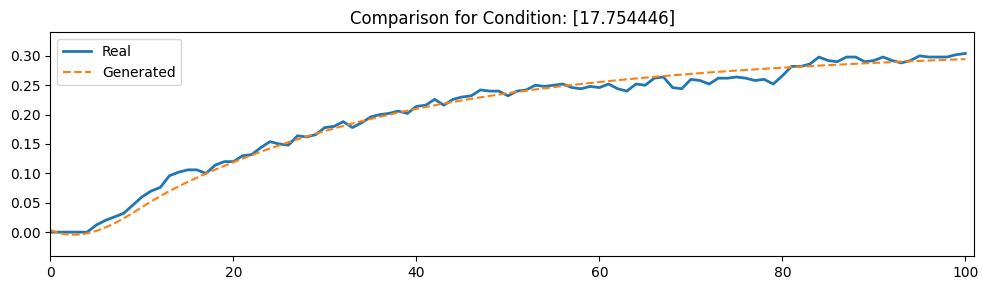

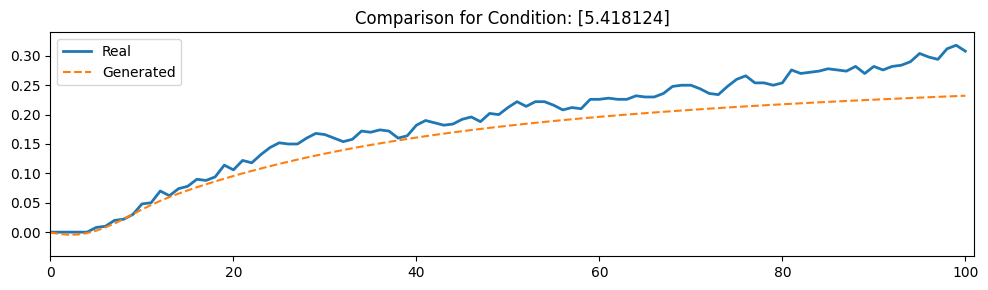

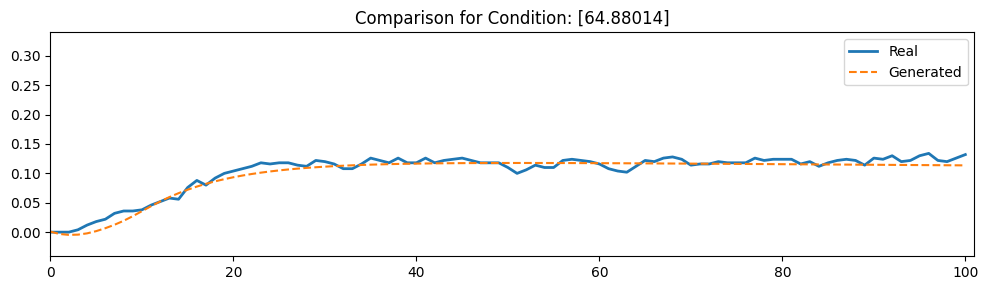

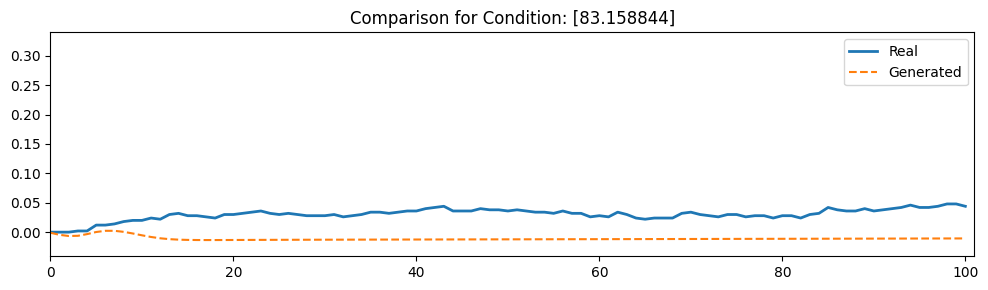

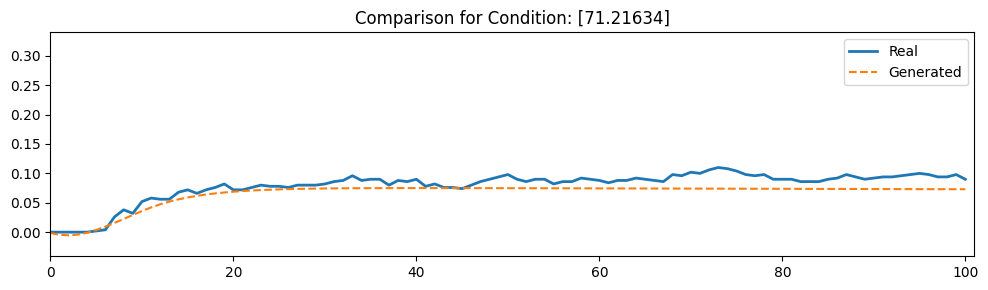

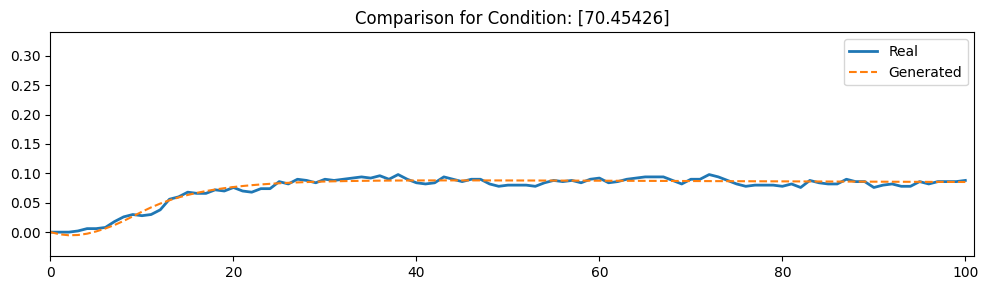

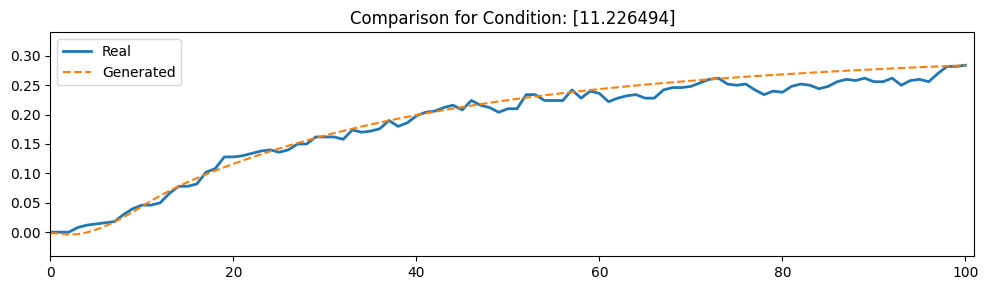

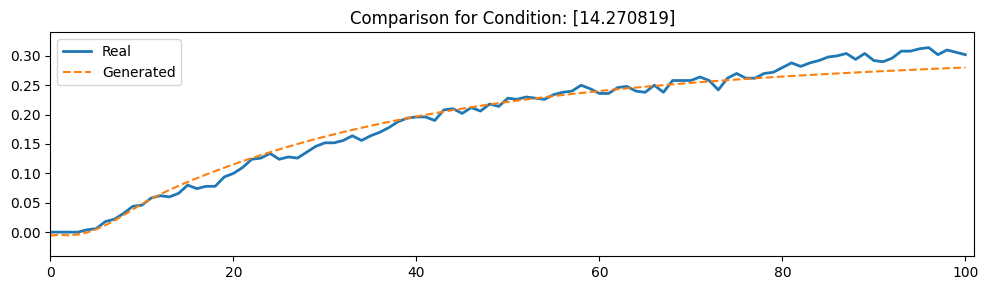

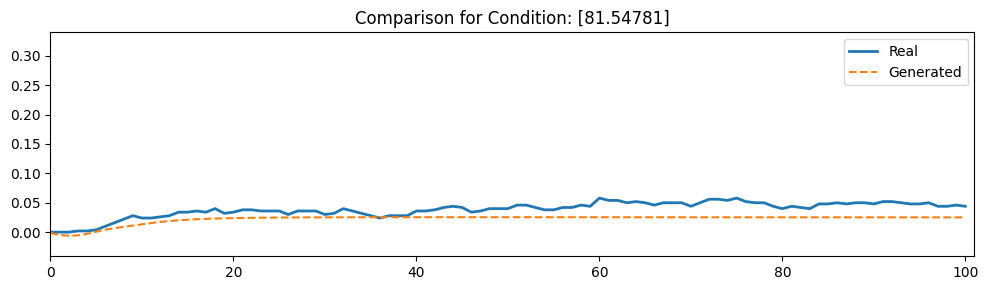

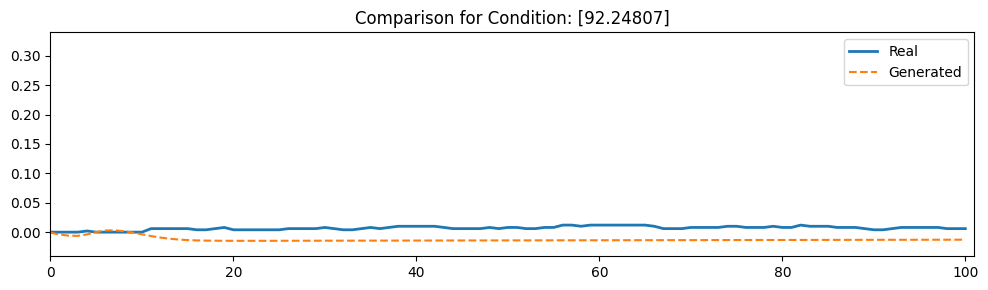

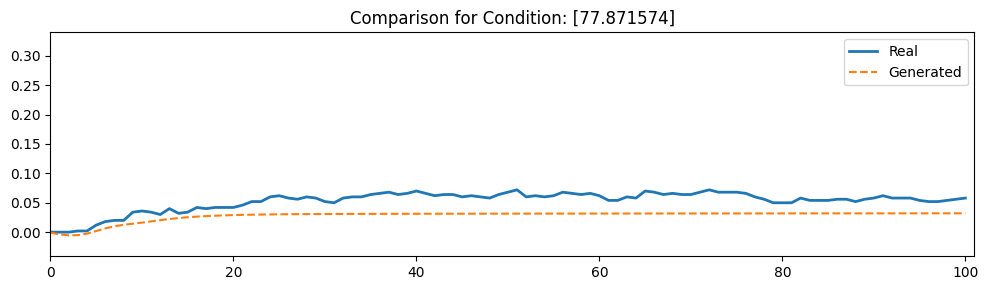

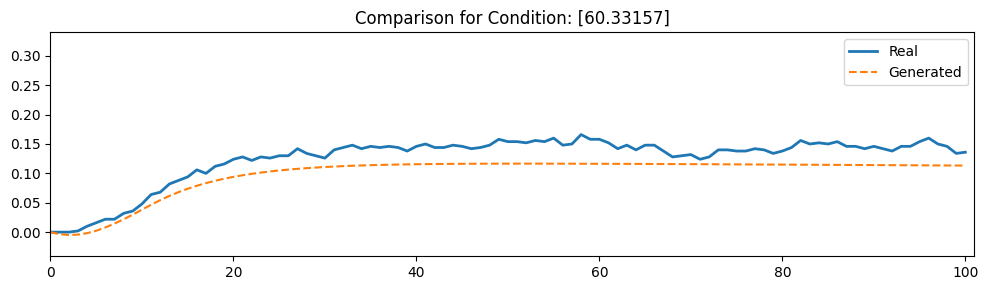

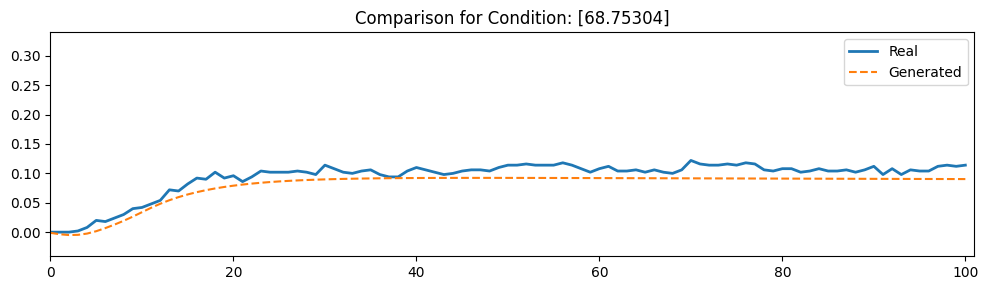

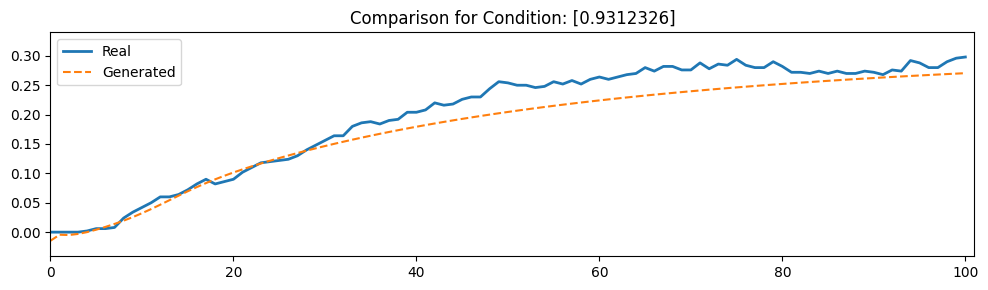

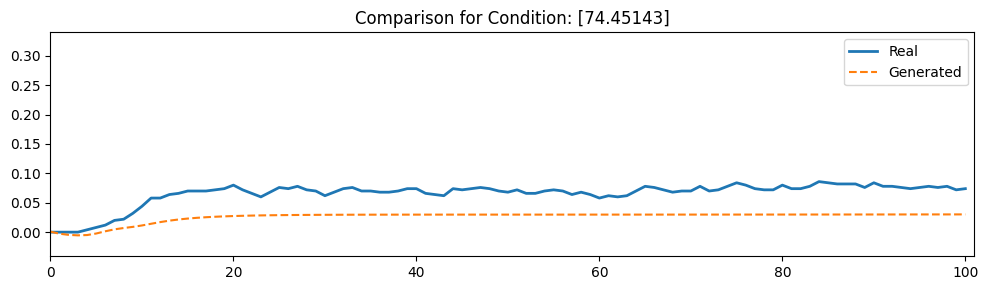

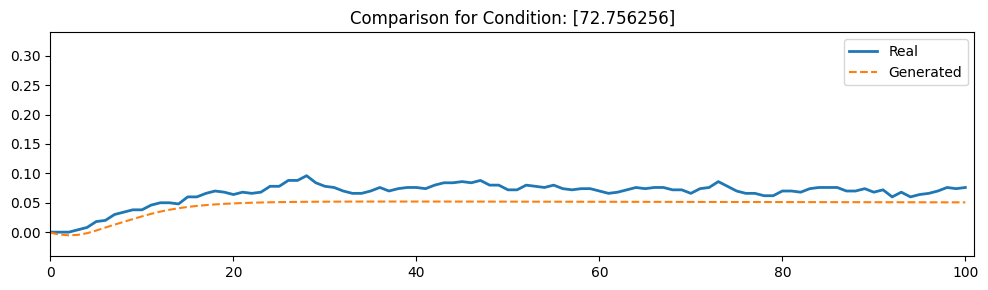

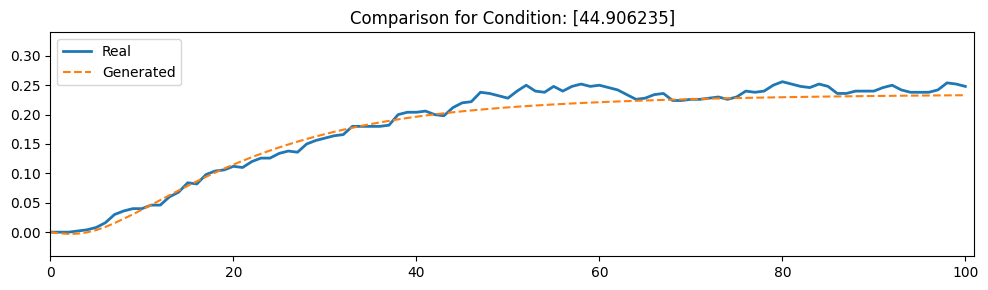

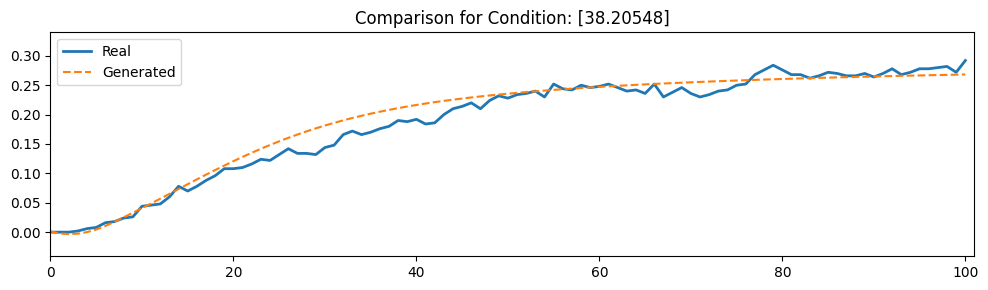

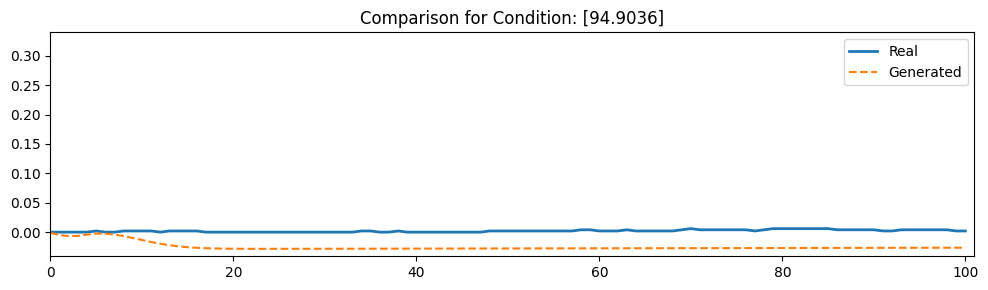

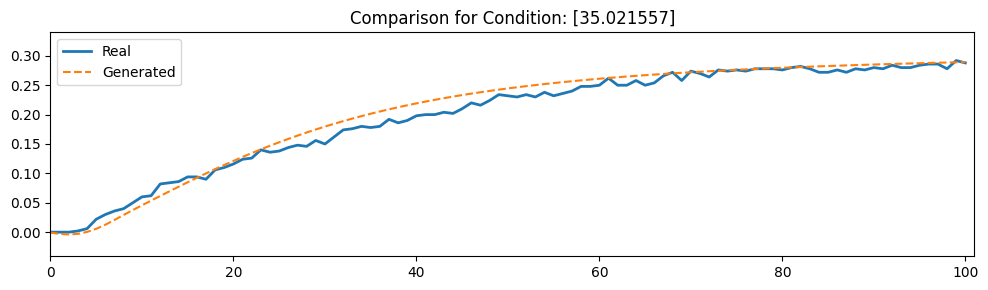

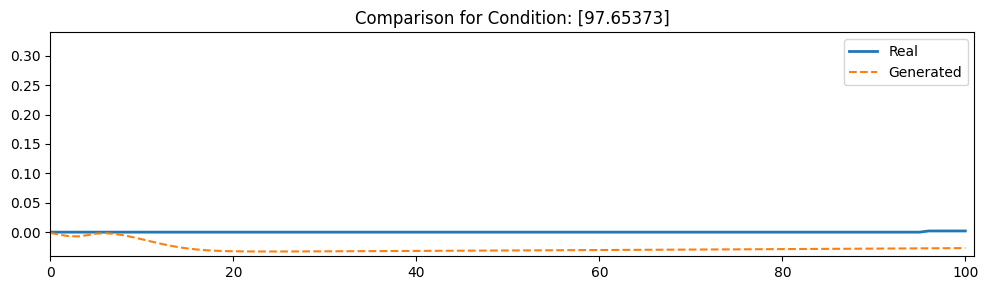

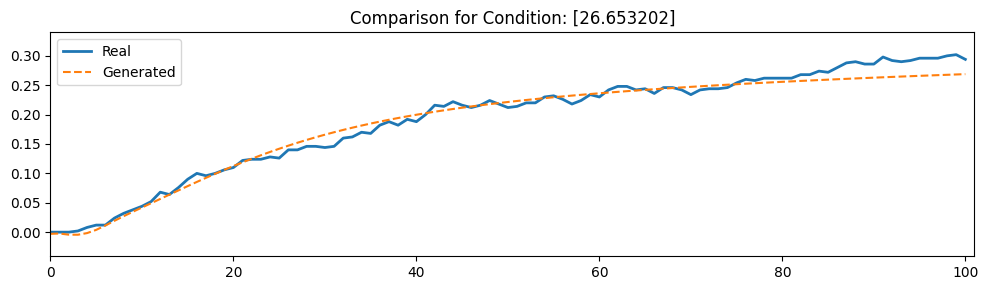

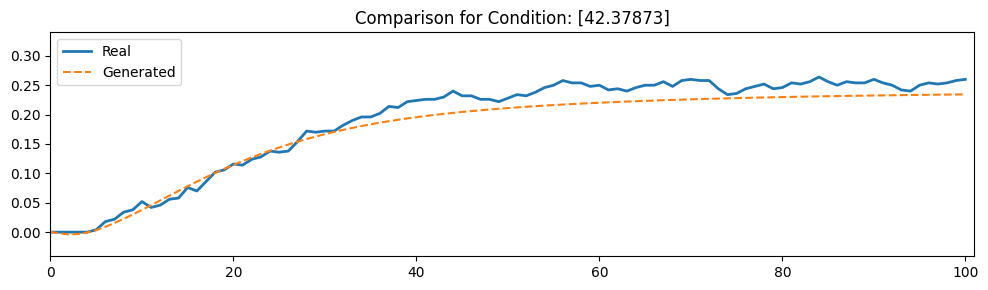

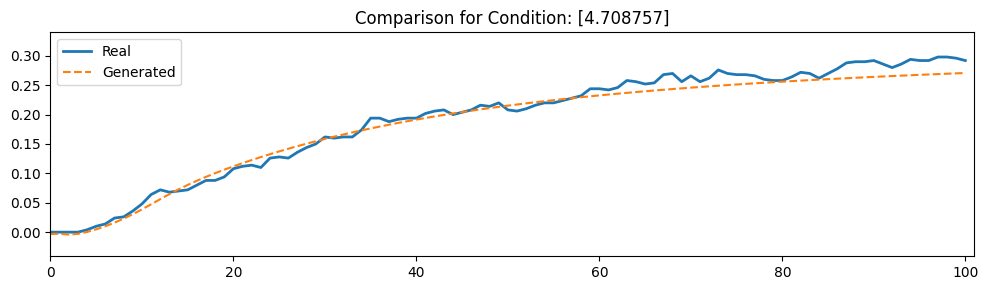

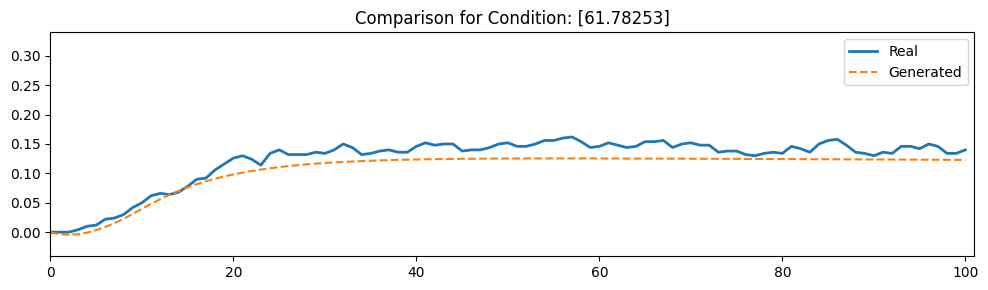

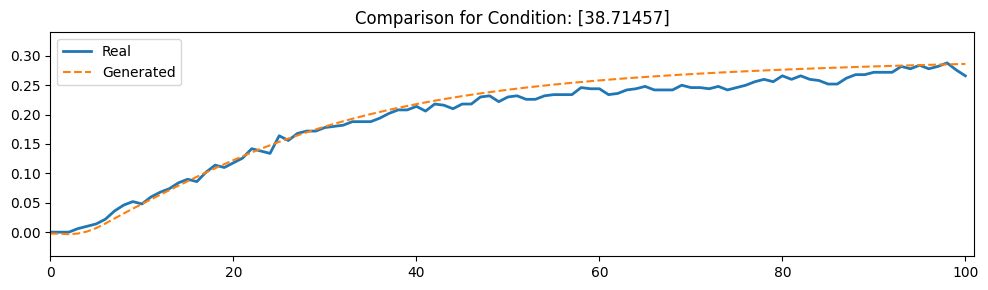

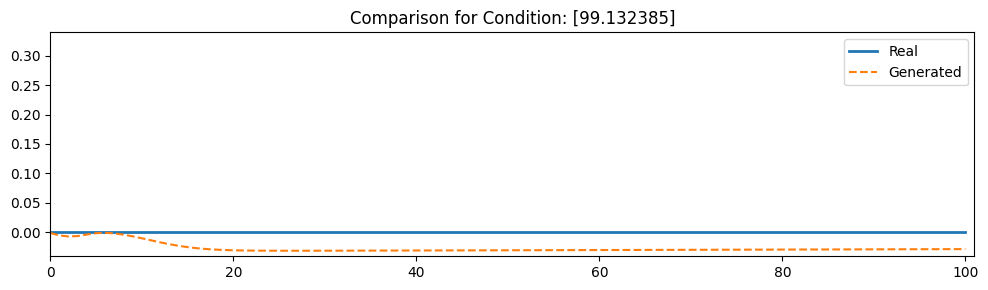

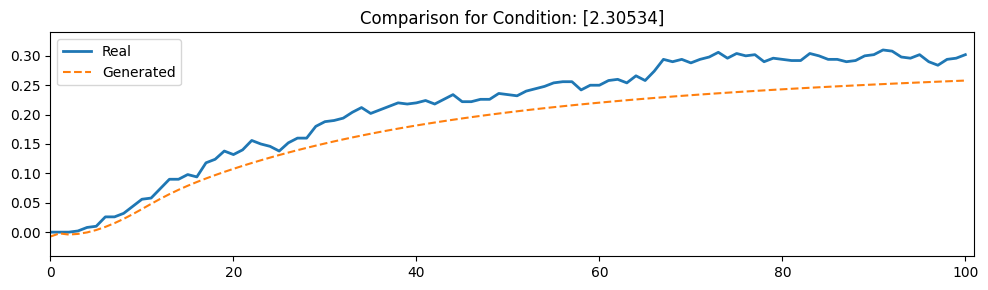

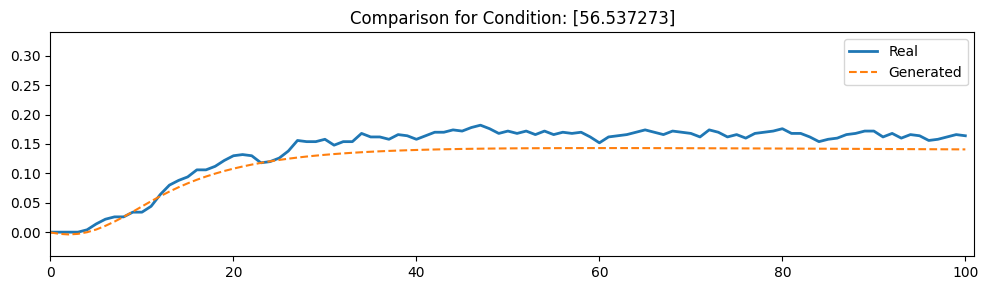

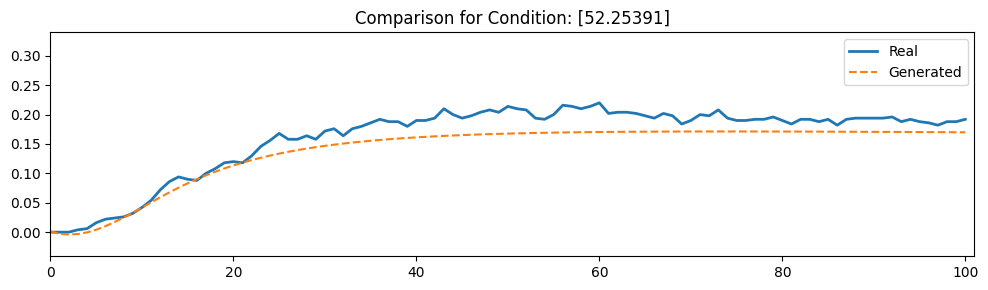

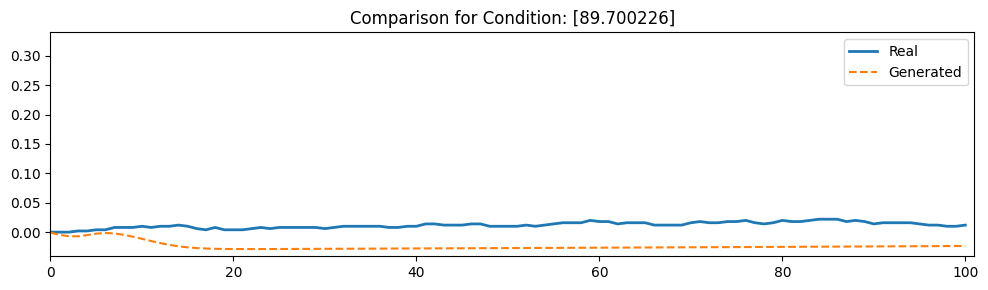

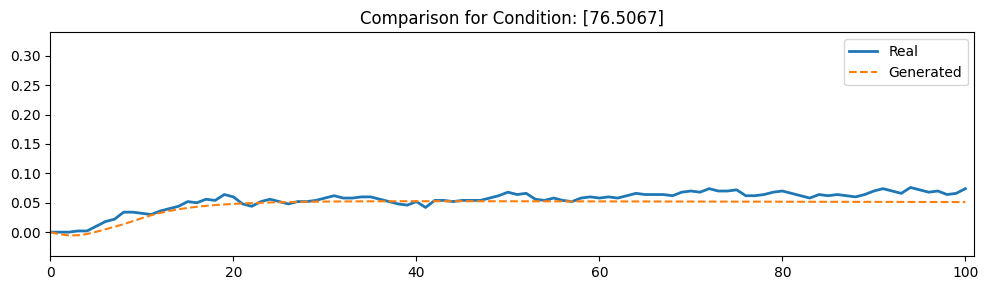

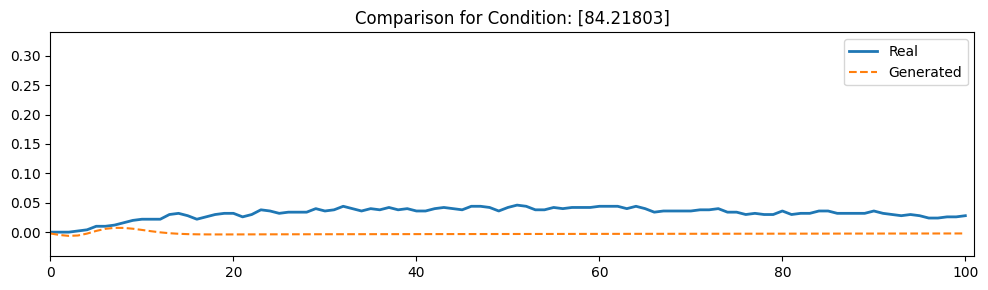

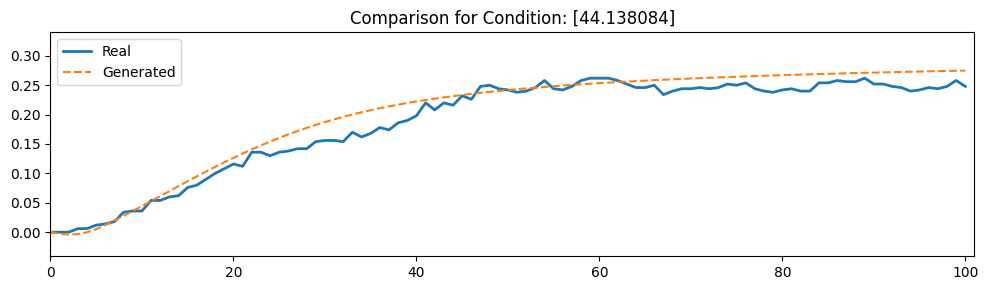

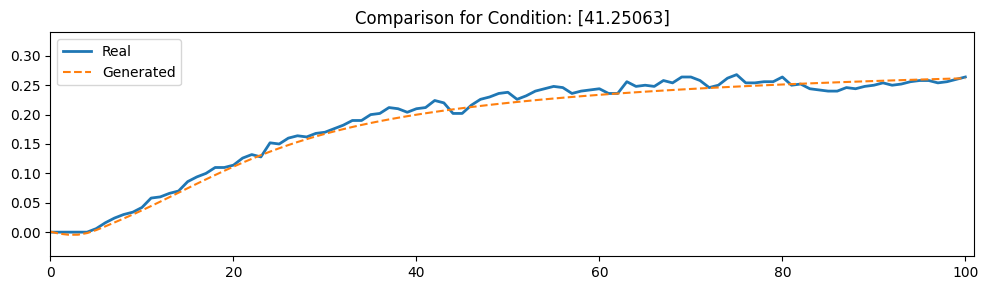

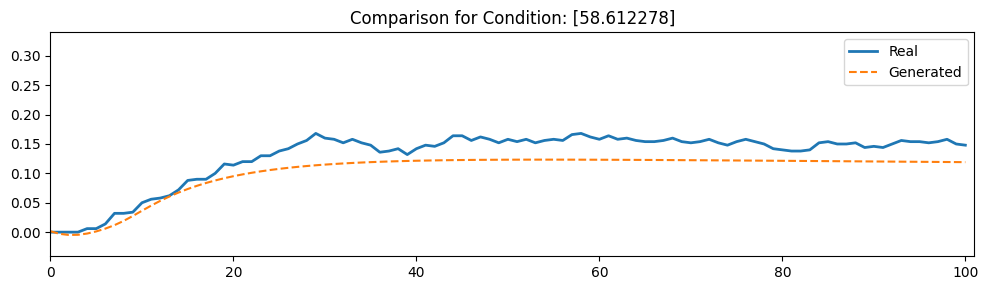

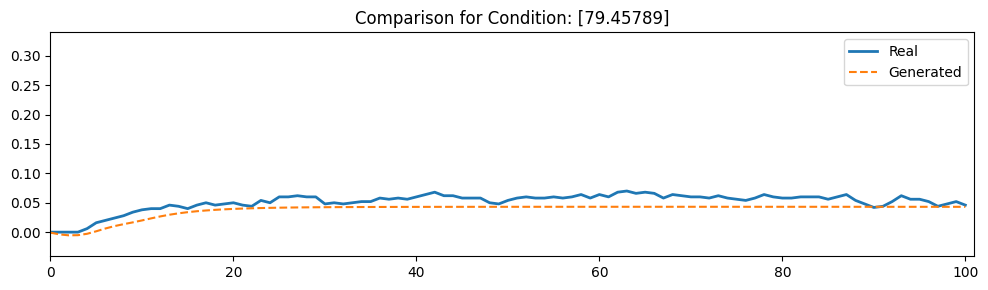

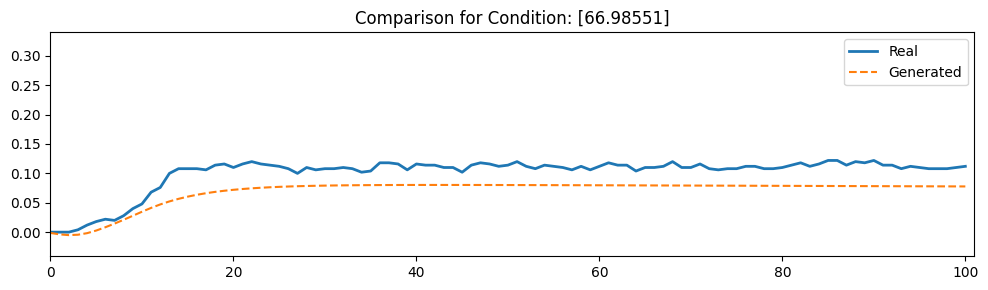

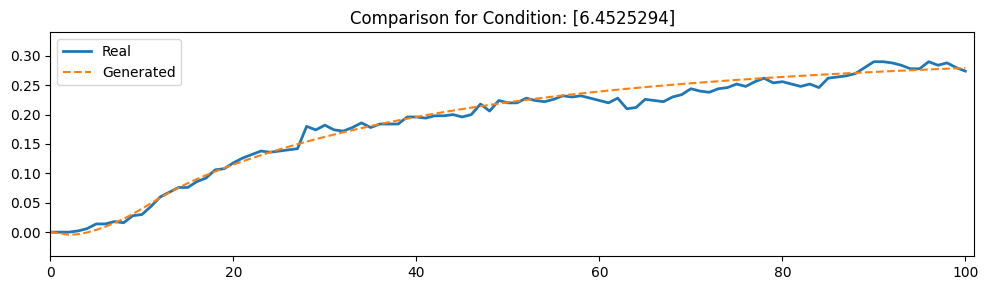

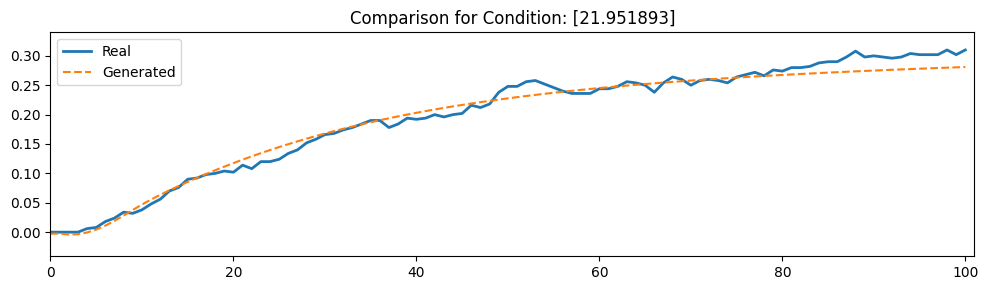

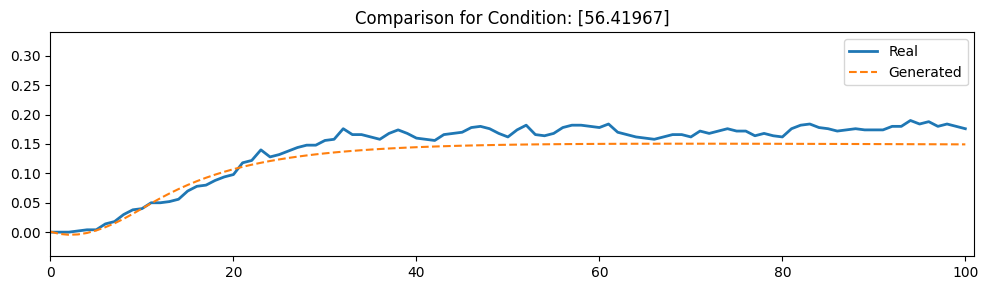

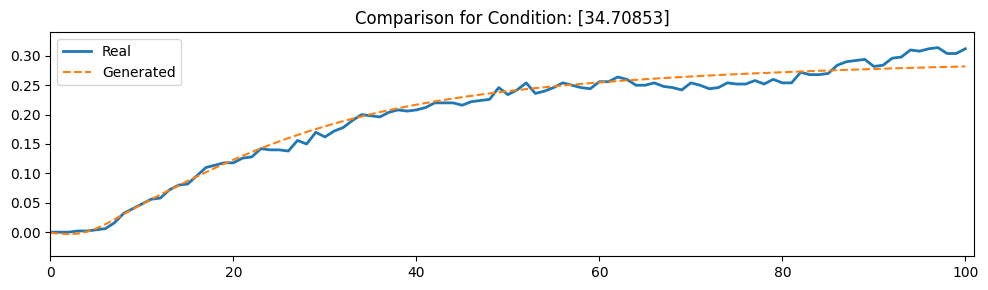

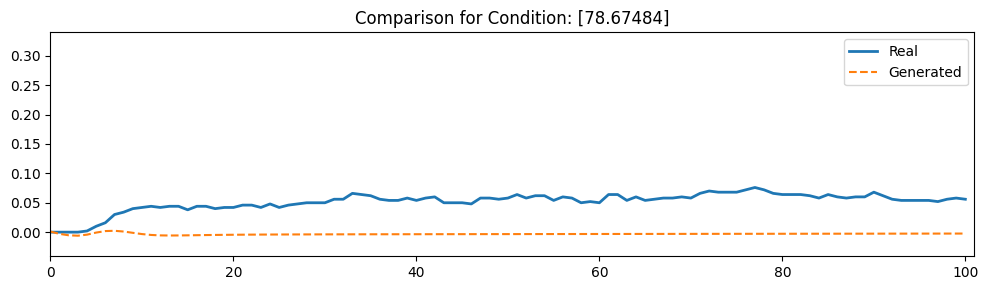

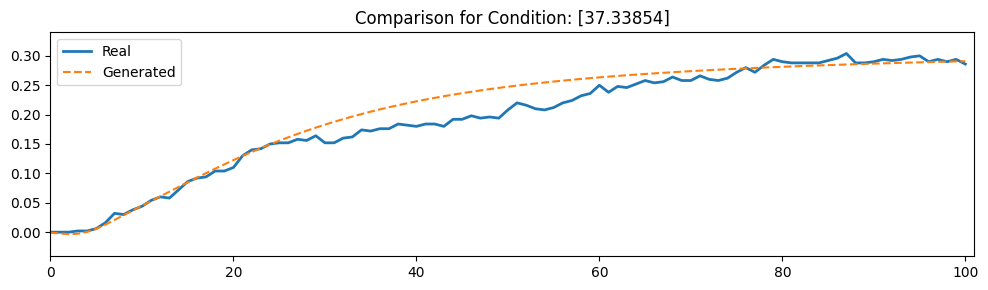

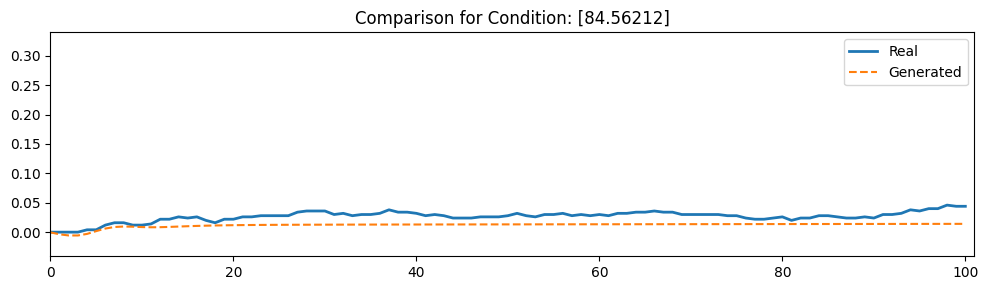

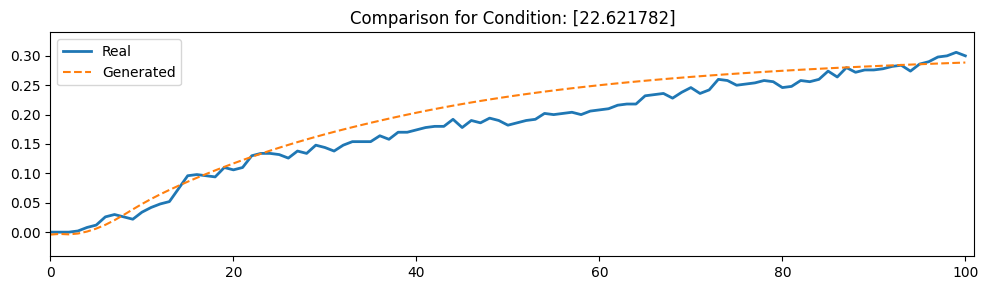

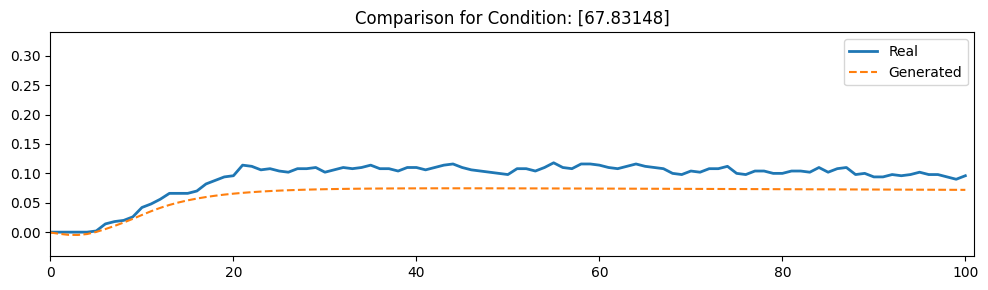

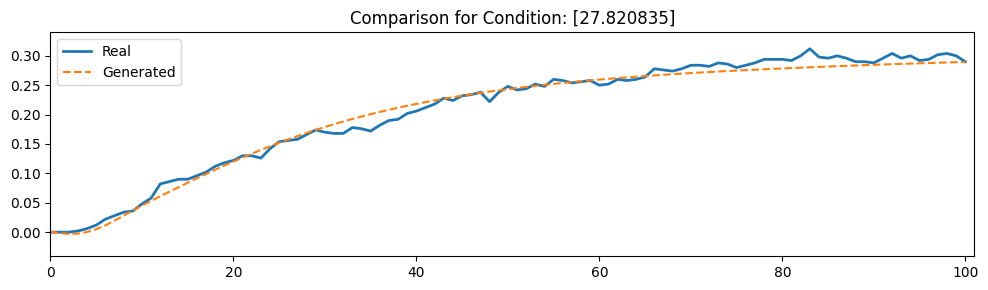

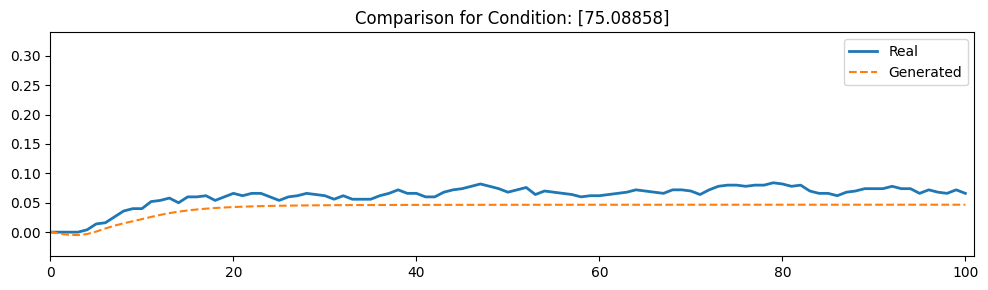

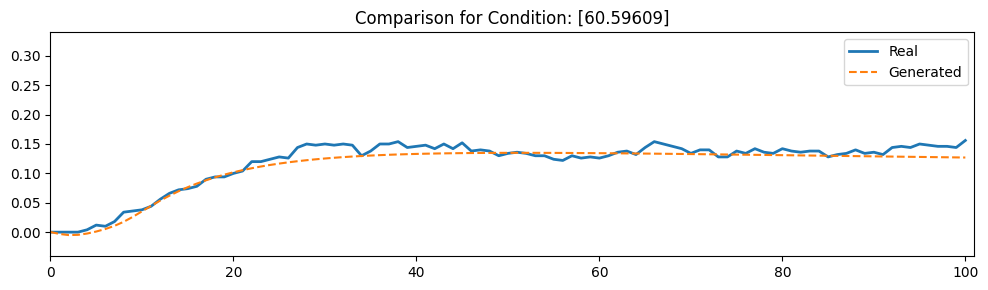

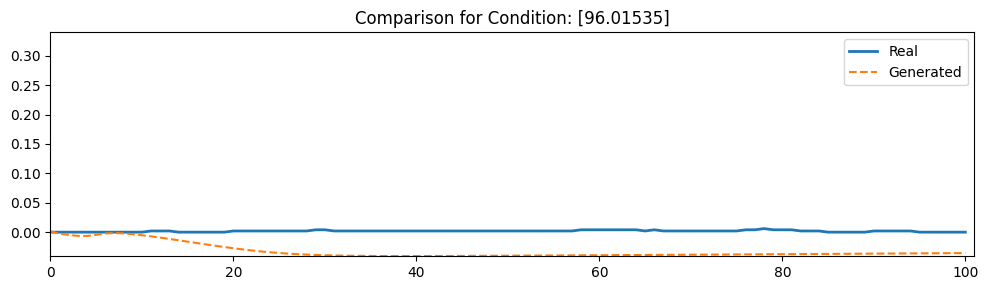

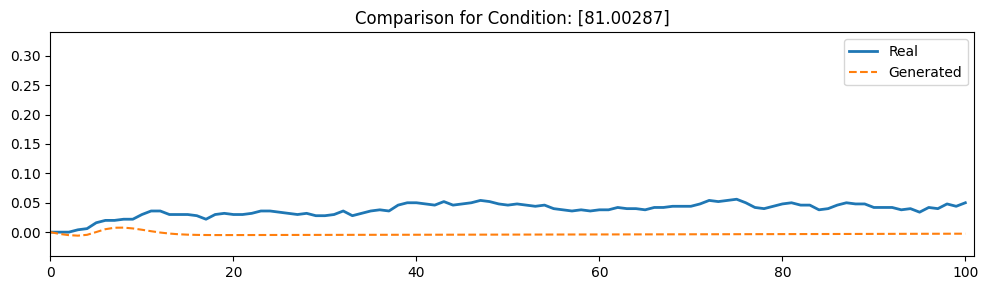

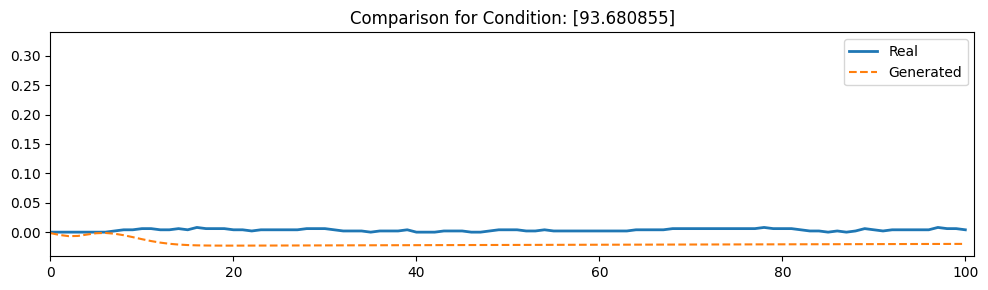

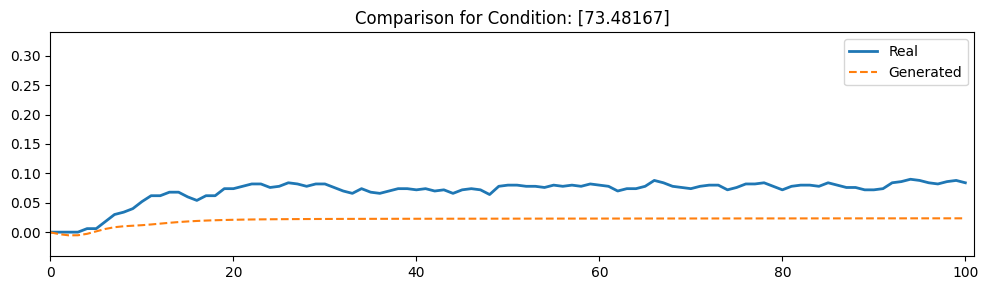

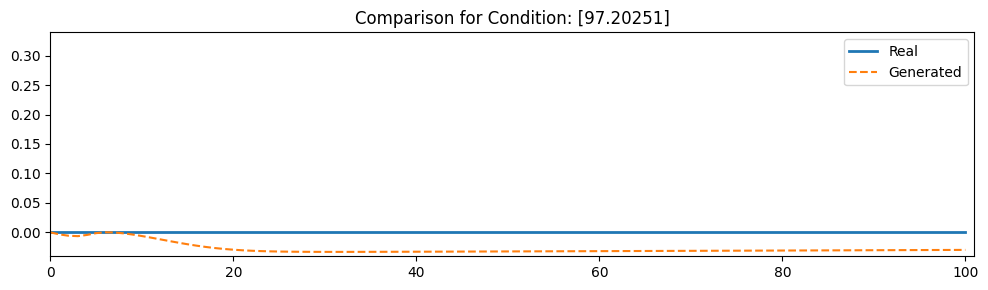

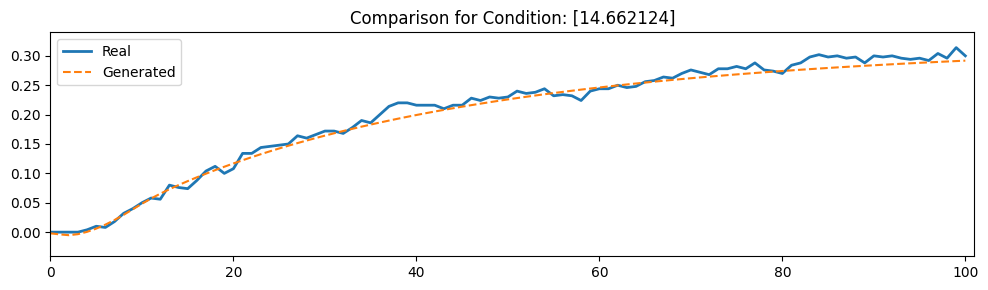

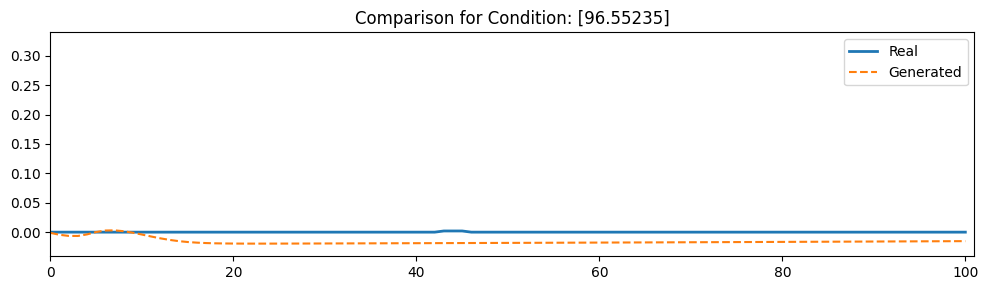

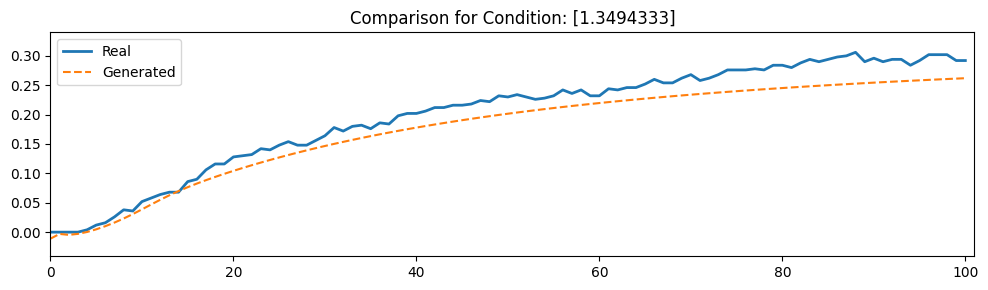

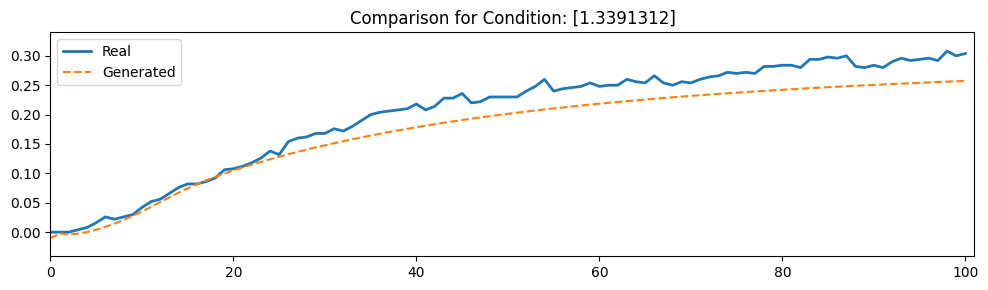

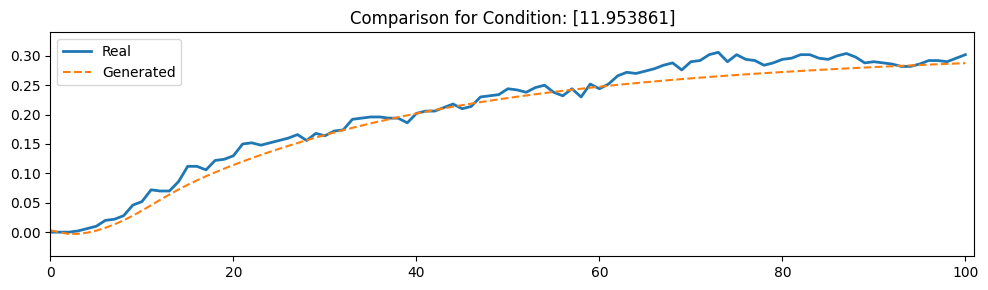

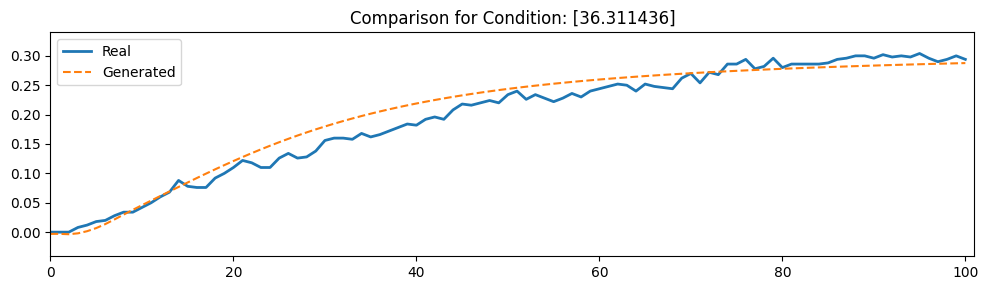

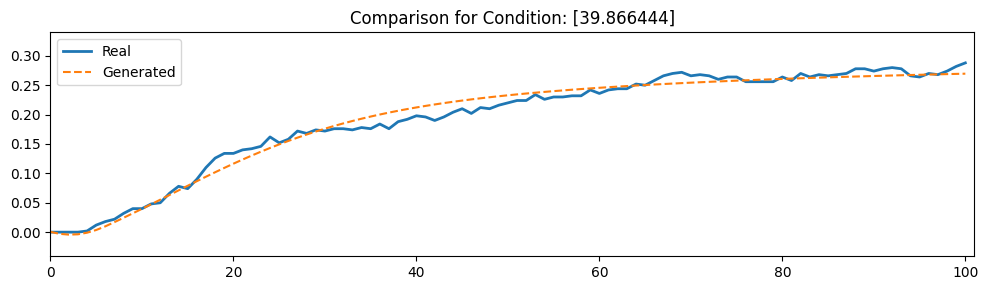

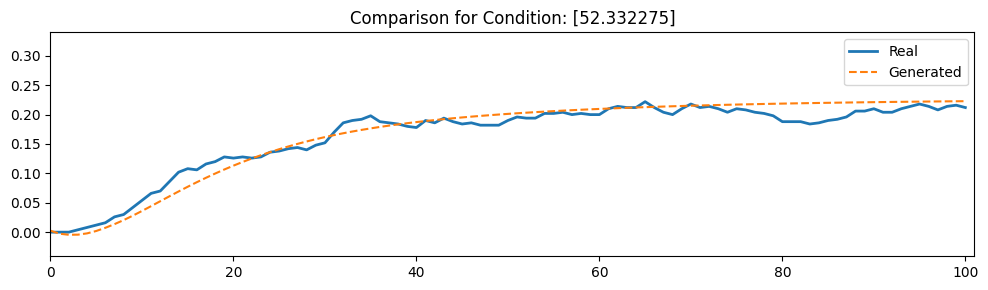

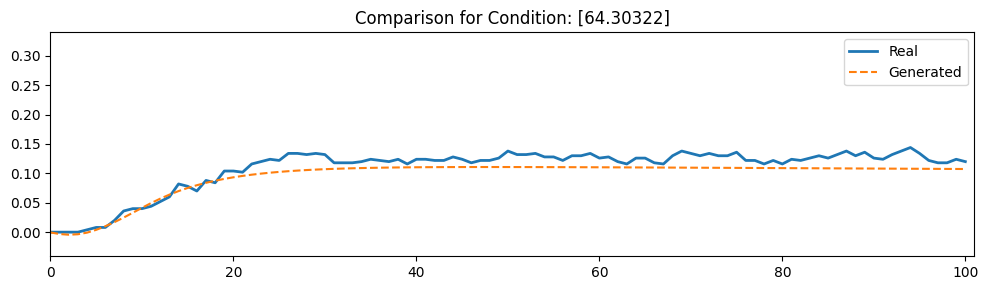

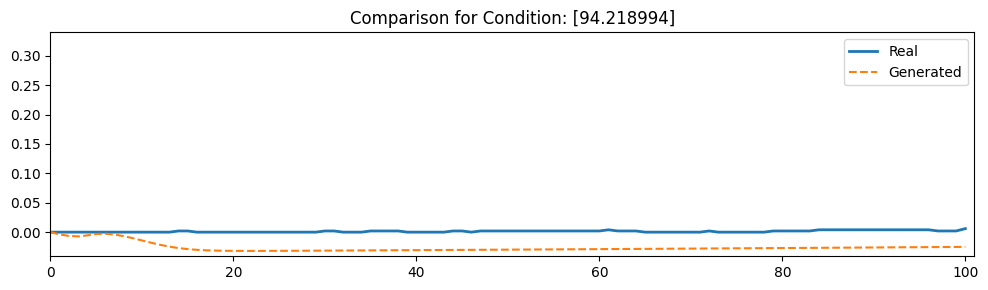

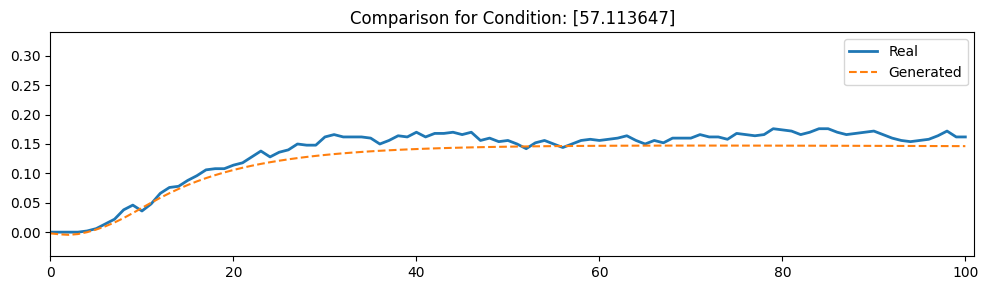

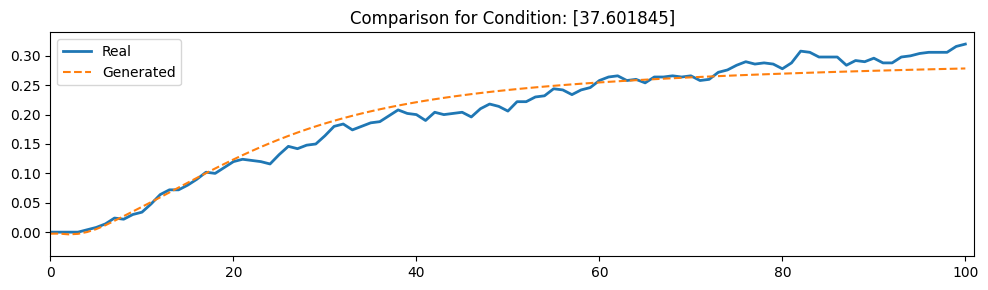

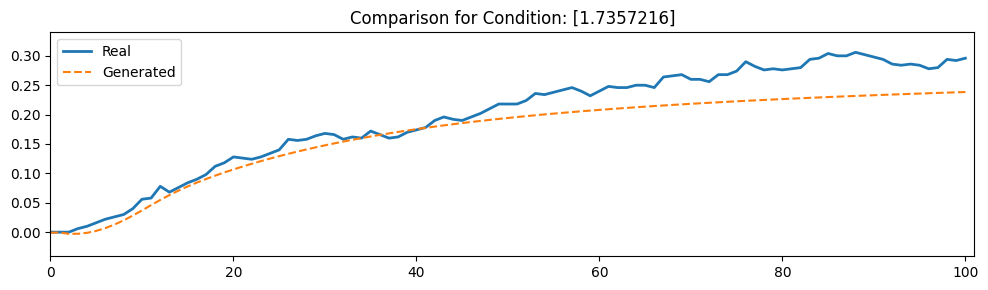

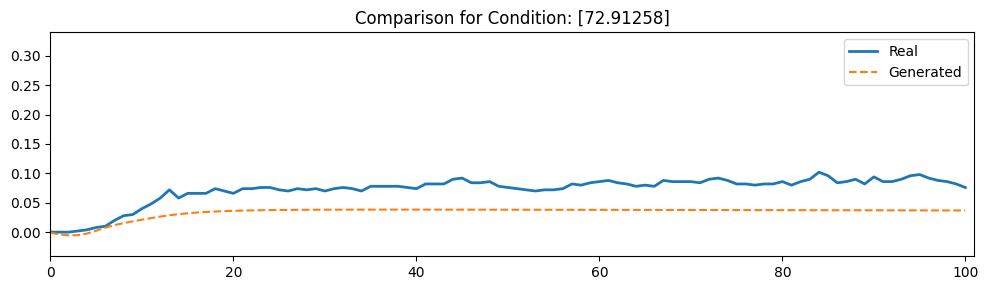

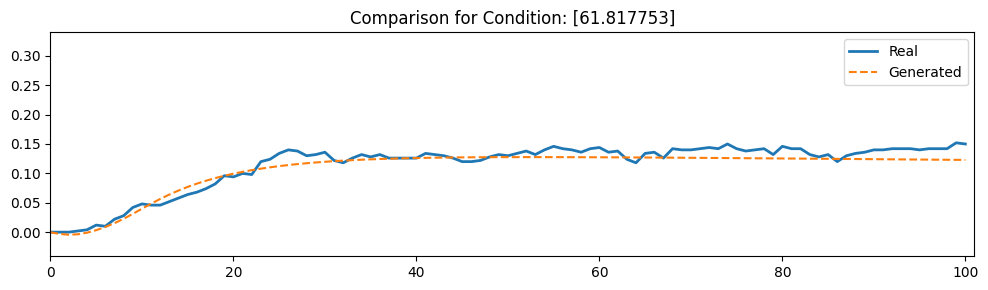

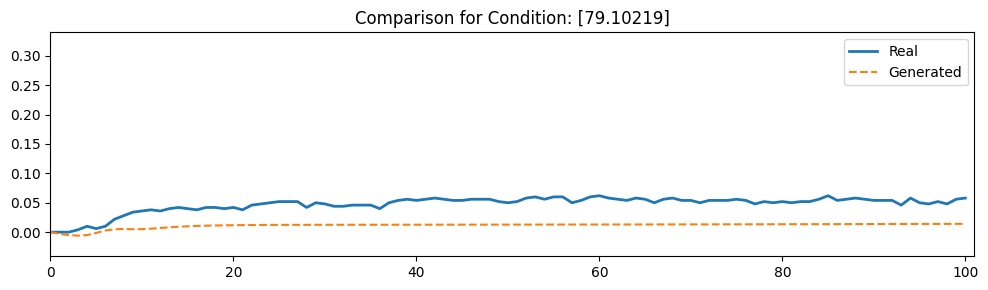

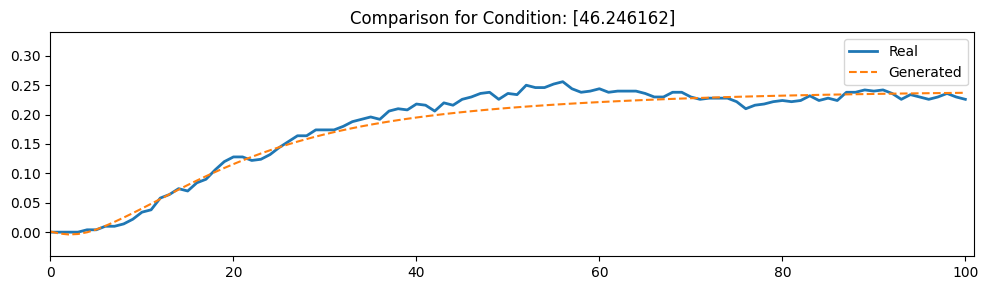

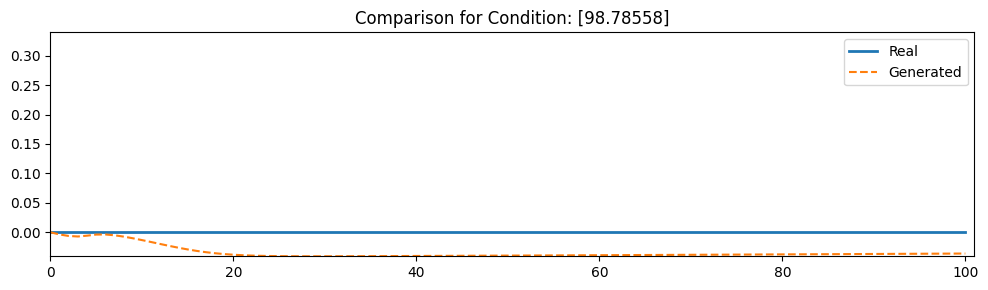

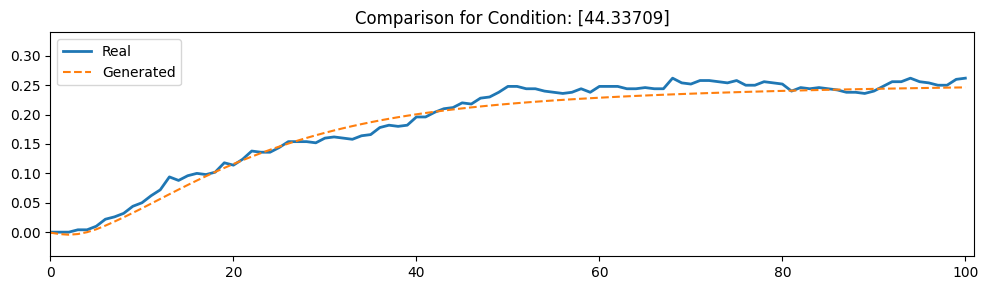

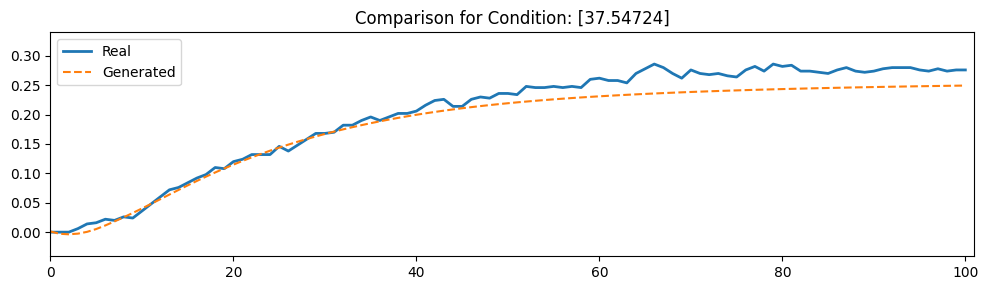

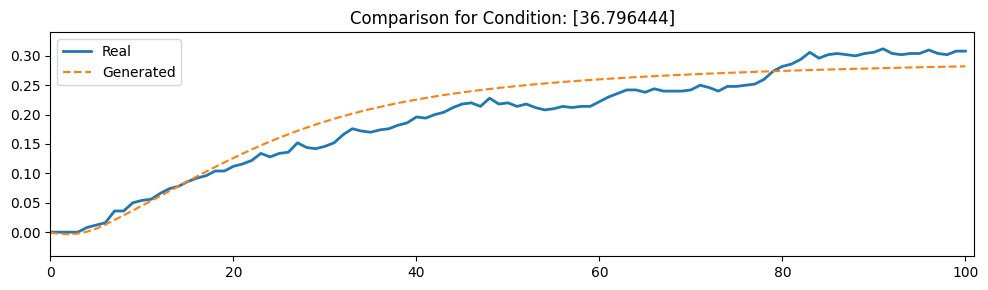

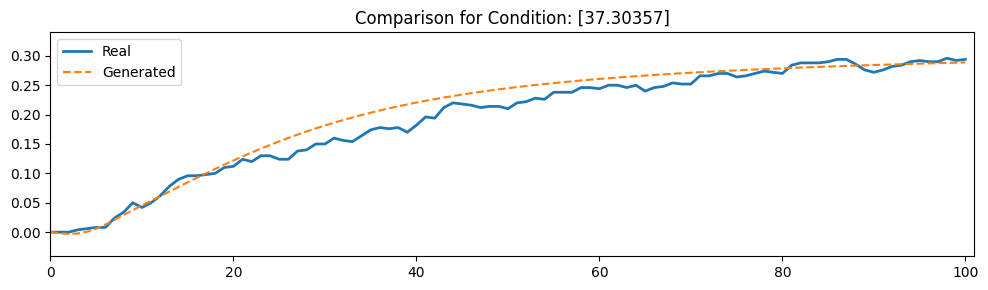

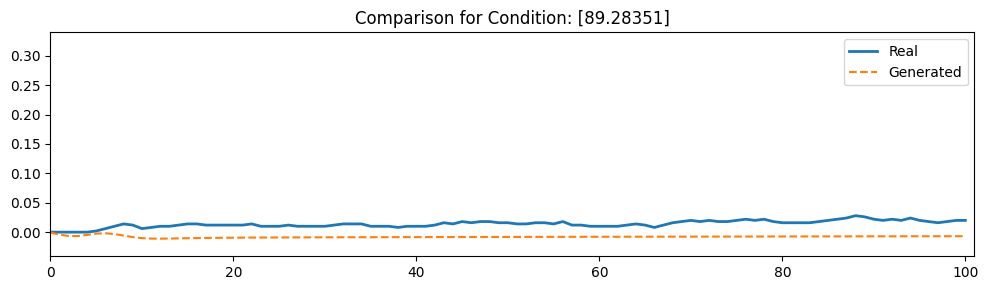

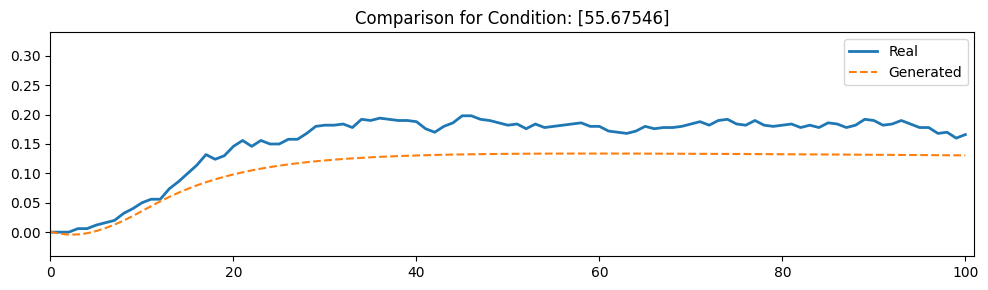

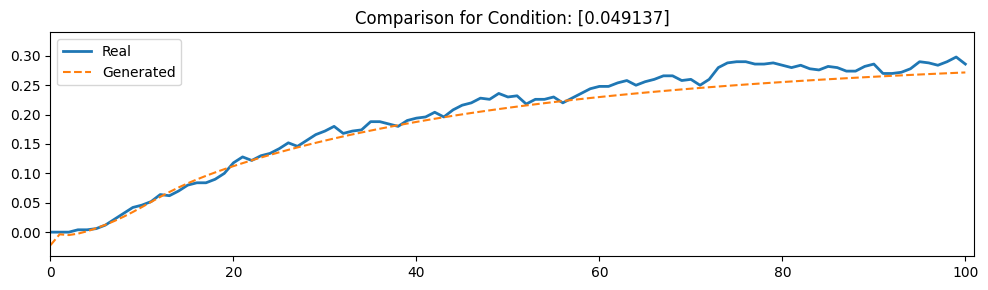

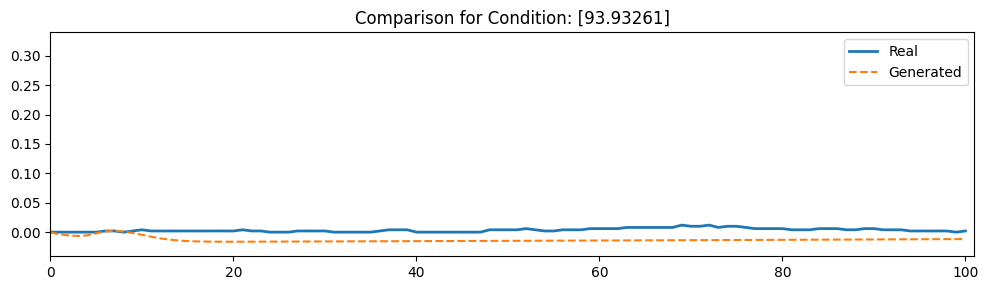

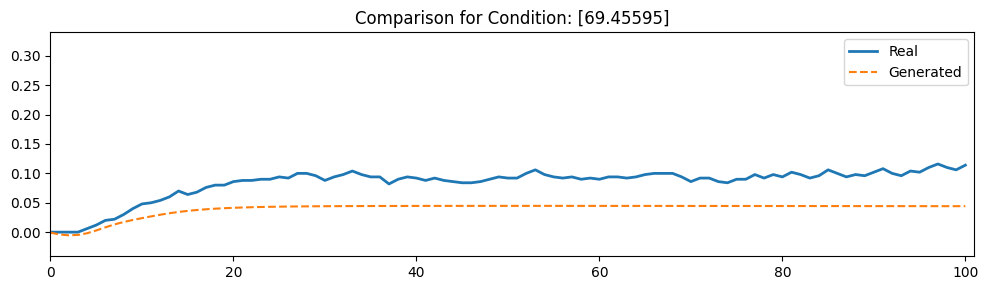

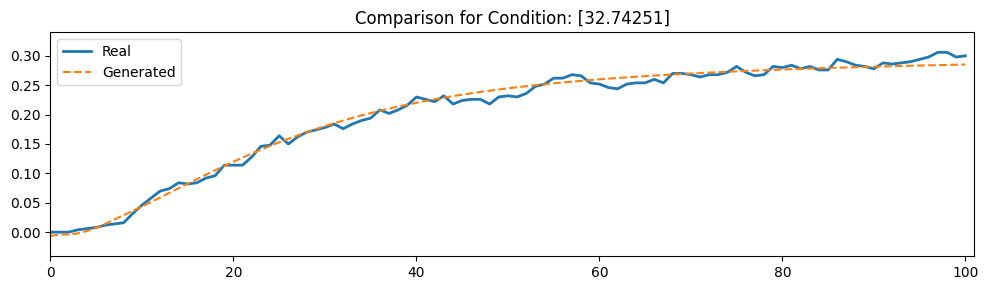

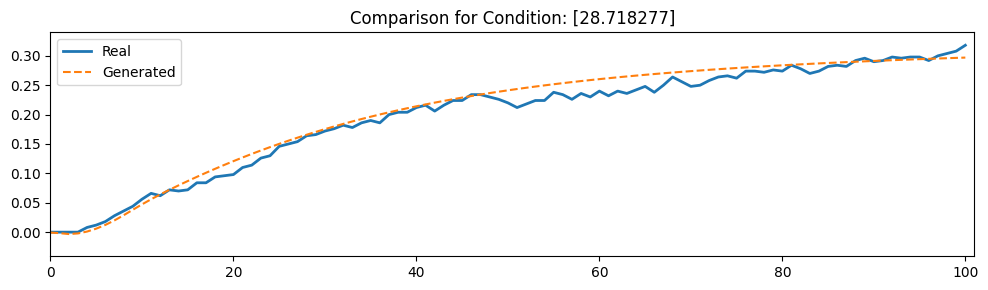

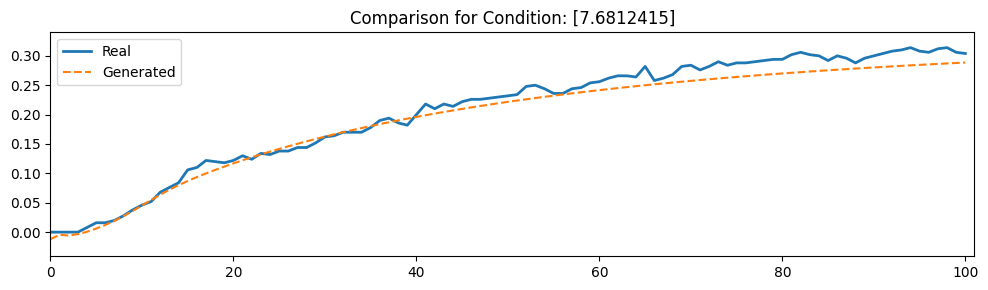

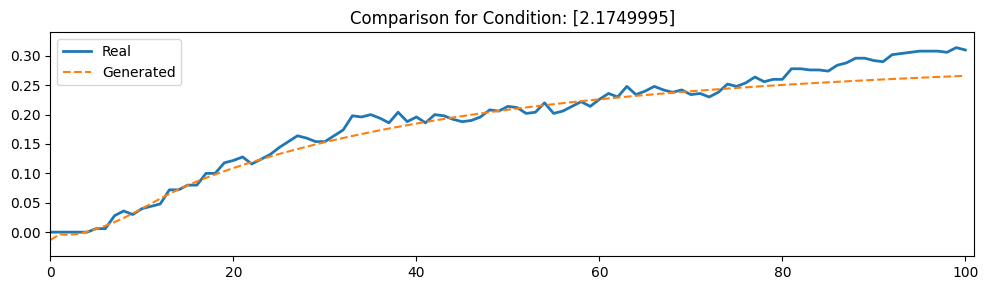

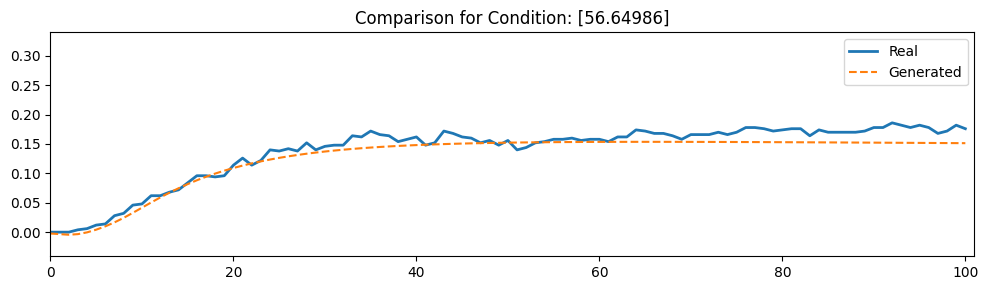

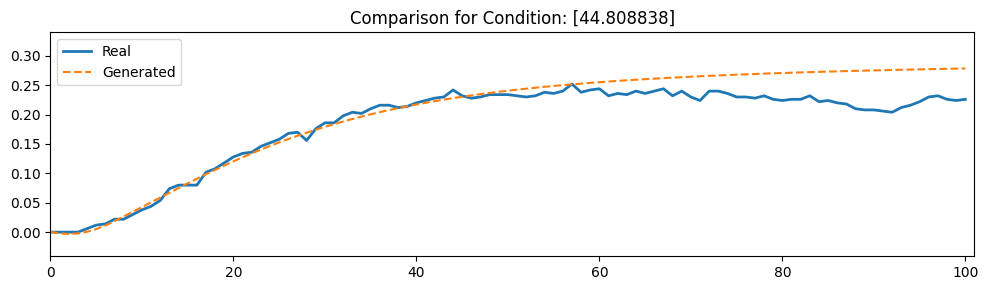

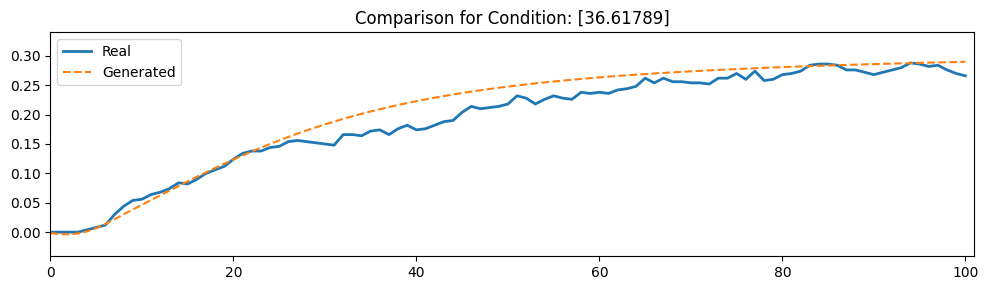

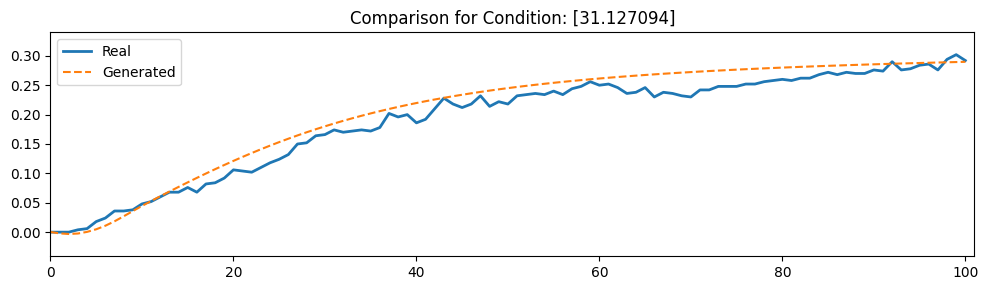

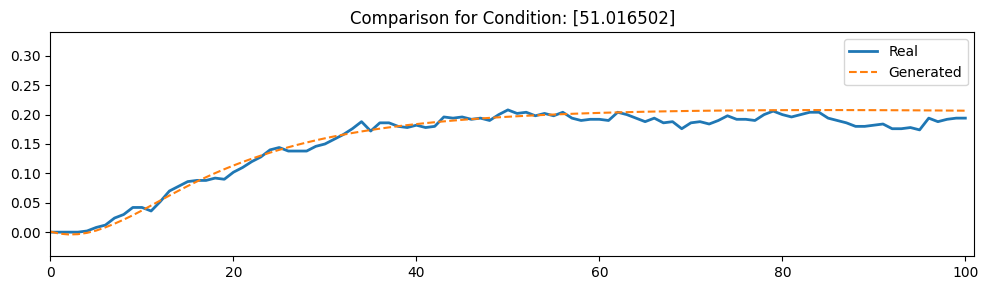

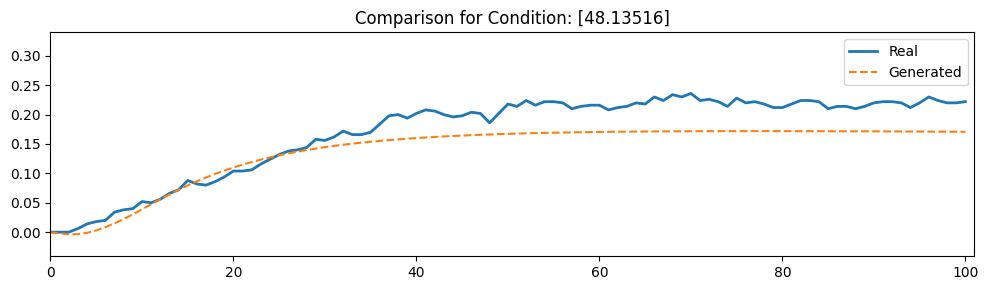

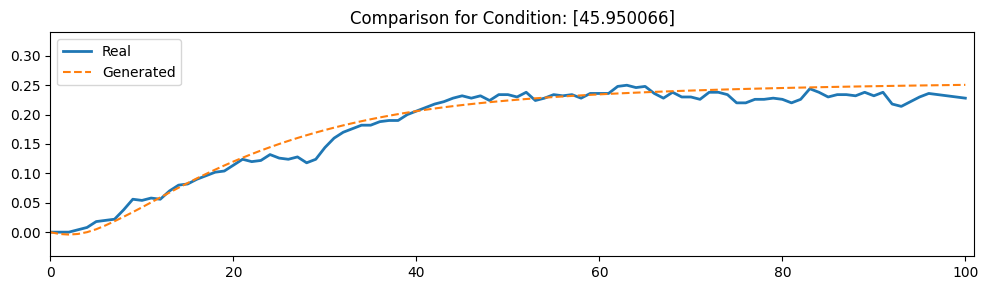

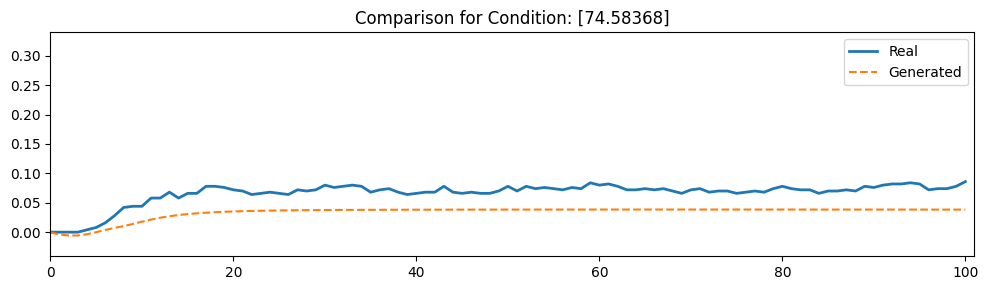

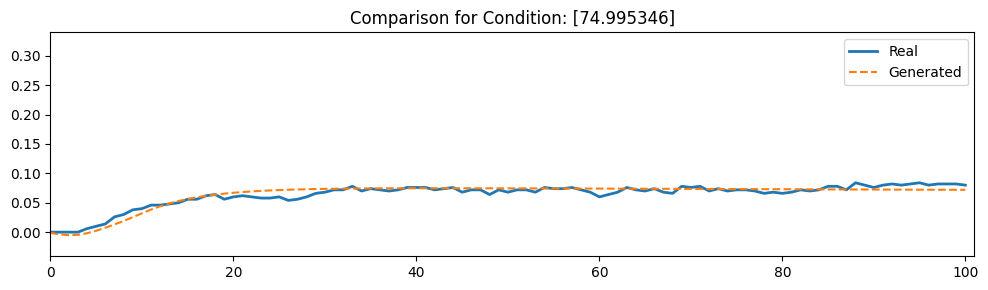

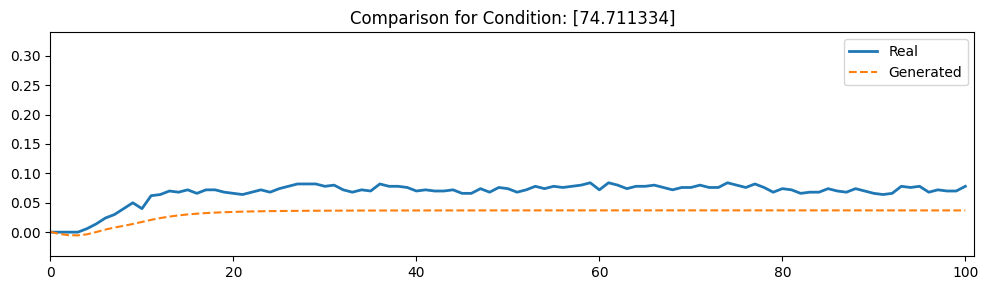

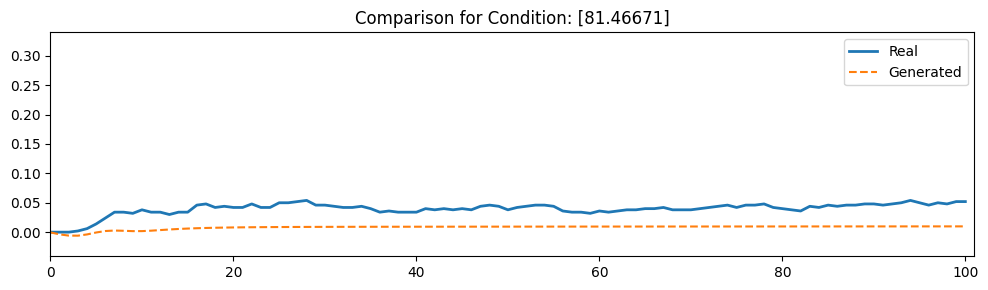

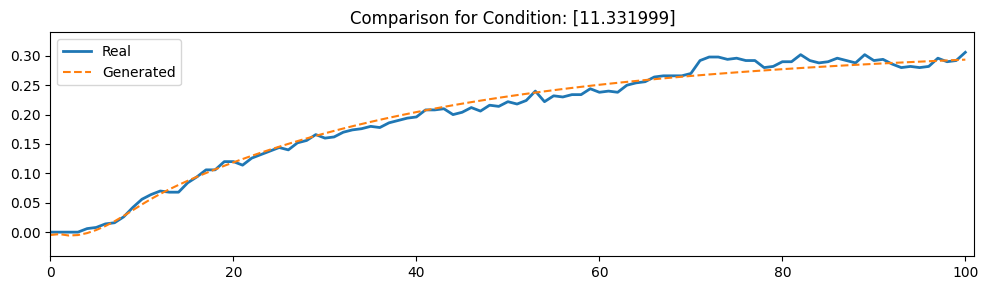

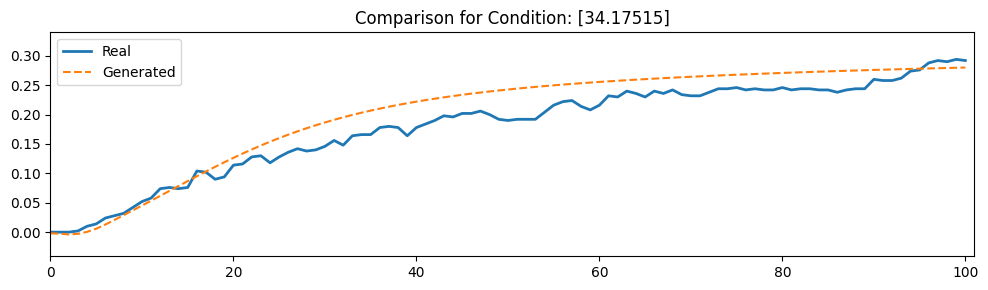

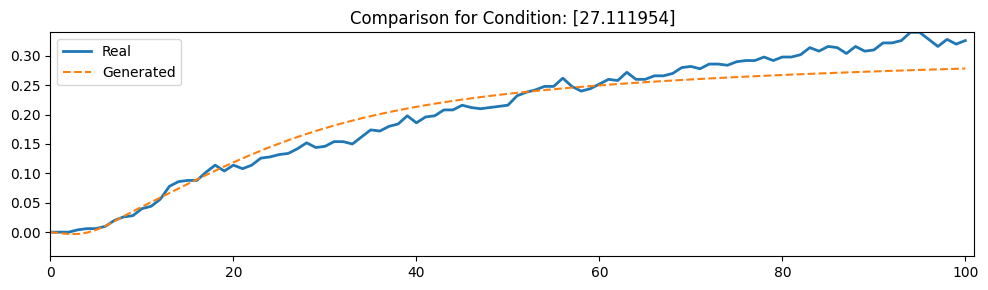

In [25]:
import matplotlib.pyplot as plt

# Calculate the global min and max for both real and generated samples
min_val = min(real_samples.min(), generated_samples.min())
max_val = max(real_samples.max(), generated_samples.max())

# Assuming real_samples, generated_samples, and real_conditions are already in the correct shape

for i in range(n_samples):
    plt.figure(figsize=(10, 3))
    plt.plot(real_samples[i].cpu().numpy(), label="Real", linewidth=2)
    plt.plot(generated_samples[i].cpu().numpy(), label="Generated", linestyle="--")
    
    # Set the axis limits based on global min and max
    plt.xlim(0, len(real_samples[i]))  # Standardize x-axis (if you know your x range)
    plt.ylim(min_val, max_val)  # Standardize y-axis

    plt.title(f"Comparison for Condition: {real_conditions[i].cpu().numpy()}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [26]:
def evaluate_model_gan(real_samples, generated_samples):

    # convert list to numpy arrays
    predicted_values = generated_samples.cpu().numpy()  # [N, 255, 1]
    true_values = real_samples.cpu().numpy()            # [N, 255, 1]

    # flatten for metrics
    y_pred_flat = predicted_values.flatten()
    y_true_flat = true_values.flatten()
    
    # compute evaluation metrics
    mse = mean_squared_error(y_true_flat, y_pred_flat)
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    r2 = r2_score(y_true_flat, y_pred_flat)

    print(f"Validation MSE: {mse:.6f}")
    print(f"Validation MAE: {mae:.6f}")
    print(f"Validation R² Score: {r2:.6f}")

    return mse, mae, r2

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
evaluate_model_gan(real_samples, generated_samples)

Validation MSE: 0.000642
Validation MAE: 0.020391
Validation R² Score: 0.931143


(0.0006417292170226574, 0.02039054036140442, 0.9311431646347046)

In [28]:
import numpy as np
real_samples = []
real_conditions = []

for idx in np.arange(len(valid_dataset)):
    real_ts, condition = valid_dataset[idx]
    real_samples.append(real_ts)
    real_conditions.append(condition)

real_samples = torch.stack(real_samples)           # (n_samples, 252)
real_conditions = torch.stack(real_conditions)     # (n_samples, 3)

generator.eval()
with torch.no_grad():
    latent_dim = 100 # or whatever your latent size is
    z = torch.randn(len(valid_dataset), latent_dim)
    generated_samples = generator(z, real_conditions)  # (n_samples, 252)

evaluate_model_gan(real_samples, generated_samples)

Validation MSE: 0.000572
Validation MAE: 0.019162
Validation R² Score: 0.938615


(0.0005721724010072649, 0.019162049517035484, 0.938615083694458)